# Create dataset
- Merging datasets from both stage 3 and stage 4
- Map stage and spectrum datapoints based on time - for each spectrum datapoint we find the closest previous parameters datapoint from both stages
- Filter only rows where all the parameters do not change
- Create spectrograms
- Save created datasets for both stages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

## Load data

**stgs3_4_data:**

Parameters from which conditional vectors will be created.

In [3]:
# Load the data using Pandas
df = pd.read_csv('stgs3_4_data.txt', sep='\t', skiprows=46)  # Adjust the number of rows to skip based on the file header
df = df.dropna()  # Drop rows with any NaN values
df['Time'] = pd.to_datetime(df['Time'])  # Convert 'Time' column to datetime

df['Stage3_Stepper'] = df['L1-PL1-MTR29:RawPos Value'].str.replace(',', '').astype(float)
df['Stage4_Stepper'] = df['L1-PL2-MTR09:RawPos Value'].str.replace(',', '').astype(float)

df.drop(columns=['L1-PL1-MTR29:RawPos Value', 'L1-PL2-MTR09:RawPos Value'], inplace=True)

# Rename columns for easier access (including the new split columns)
df.columns = ['Time', 'Stage3_OutputPower', 'Stage3_Piezo', 'Stage4_OutputPower', 'Stage4_Piezo', 
              'Stage3_Stepper', 'Stage4_Stepper']

In [4]:
df.head()

Time  Stage3_OutputPower  Stage3_Piezo  \
5 2024-06-14 18:46:29.766817093            0.017161           0.0   
6 2024-06-17 08:58:45.360144138            0.017161           0.0   
7 2024-06-17 08:58:45.609766960            0.072318           0.0   
8 2024-06-17 08:58:46.115516186            0.072318           0.0   
9 2024-06-17 08:58:46.396927834            0.072318           0.0   

   Stage4_OutputPower  Stage4_Piezo  Stage3_Stepper  Stage4_Stepper  
5            0.083602           0.0       -176387.0       -289957.0  
6            0.153892           0.0       -176387.0       -289957.0  
7            0.153892           0.0       -176387.0       -289957.0  
8            0.223622           0.0       -176387.0       -289957.0  
9            0.089850           0.0       -176387.0       -289957.0

**processed_stg3spec and processed_stg4spec**:

Processed data containing info about spectrum wevelengths' intensities in time from stages 3 and 4.

In [5]:
processed_stg3 = pd.read_csv('processed_stg3spec.csv')

# Convert the 'Time' column in processed_stg3 to datetime format
processed_stg3['Time'] = pd.to_datetime(processed_stg3['Time'])

processed_stg4 = pd.read_csv('processed_stg4spec.csv')

# Convert the 'Time' column in processed_stg3 to datetime format
processed_stg4['Time'] = pd.to_datetime(processed_stg4['Time'])

## Mapping time

In [6]:
# Sort both dataframes by the Time column
df = df.sort_values(by='Time').reset_index(drop=True)
processed_stg3 = processed_stg3.sort_values(by='Time').reset_index(drop=True)
processed_stg4 = processed_stg4.sort_values(by='Time').reset_index(drop=True)

In [7]:
def filter_and_find_closest_times(processed_stg, df, start_time0, start_time1, end_time):
    """
    Filters `processed_stg` and `df` based on specified time ranges, adds 'idx' column to `df`,
    and merges them to find closest previous times in `df` for each row in `processed_stg`.
    
    Parameters:
    - processed_stg (pd.DataFrame): The DataFrame with spectrum times.
    - df (pd.DataFrame): The DataFrame with parameters times.
    - start_time0 (pd.Timestamp): Start time for filtering `df`.
    - start_time1 (pd.Timestamp): Start time for filtering `processed_stg`.
    - end_time (pd.Timestamp): End time for filtering both DataFrames.
    
    Returns:
    - pd.DataFrame: Merged DataFrame containing the closest previous times.
    """
    # Filter the DataFrames based on the specified time range
    filtered_processed_stg = processed_stg[(processed_stg['Time'] >= start_time1) & 
                                           (processed_stg['Time'] <= end_time)]
    filtered_df = df[(df['Time'] >= start_time0) & (df['Time'] <= end_time)].copy()

    # Add 'idx' column to filtered_df
    filtered_df.loc[:, 'idx'] = filtered_df.index

    # Merge the DataFrames to find closest previous times
    closest_times_stg = pd.merge_asof(
        filtered_processed_stg.rename(columns={'Time': 'Time_spectrum'}),
        filtered_df.rename(columns={'Time': 'Time_parameters'}),
        left_on='Time_spectrum',
        right_on='Time_parameters',
        direction='backward'
    )

    return closest_times_stg

### parameters and stage3

In [8]:
# Define the time range
start_time0 = pd.Timestamp('2024-06-17 08:58:00')
start_time1 = pd.Timestamp('2024-06-17 08:59:00')
end_time = pd.Timestamp('2024-06-17 10:27:00')

# Call the function
closest_times_stg3 = filter_and_find_closest_times(processed_stg3, df, start_time0, start_time1, end_time)
closest_times_stg3.head()

Time_spectrum  \
0 2024-06-17 08:59:00.630595207   
1 2024-06-17 08:59:01.941629410   
2 2024-06-17 08:59:02.799632072   
3 2024-06-17 08:59:03.752634525   
4 2024-06-17 08:59:04.812631130   

                                         Intensities  \
0  [1.416987, -0.878997, -4.094142, 3.856287, -3....   
1  [2.416987, -2.878997, -3.094142, 7.856287, -2....   
2  [2.416987, 2.121003, -5.094142, 5.856287, 0.38...   
3  [4.416987, -1.878997, -1.094142, 5.856287, -4....   
4  [0.416987, -3.878997, -4.094142, 1.856287, 0.3...   

                                         Wavelengths  \
0  [634.835144, 635.296997, 635.758911, 636.22082...   
1  [634.835144, 635.296997, 635.758911, 636.22082...   
2  [634.835144, 635.296997, 635.758911, 636.22082...   
3  [634.835144, 635.296997, 635.758911, 636.22082...   
4  [634.835144, 635.296997, 635.758911, 636.22082...   

                Time_parameters  Stage3_OutputPower  Stage3_Piezo  \
0 2024-06-17 08:58:59.909673214            0.065673           0.0   
1 2024-06-17 08:59:01.923128128            0.138493           0.0   
2 2024-06-17 08:59:02.687496185            0.078878           0.0   
3 2024-06-17 08:59:03.681166172            0.073647           0.0   
4 2024-06-17 08:59:04.682624817            0.134356           0.0   

   Stage4_OutputPower  Stage4_Piezo  Stage3_Stepper  Stage4_Stepper  idx  
0            0.192273           0.0       -176387.0       -289957.0   39  
1            0.209453           0.0       -176387.0       -289957.0   44  
2            0.117521           0.0       -176387.0       -289957.0   48  
3            0.223511           0.0       -176387.0       -289957.0   53  
4            0.149874           0.0       -176387.0       -289957.0   59

### parameters and stage4

In [9]:
# Define the time range
start_time0 = pd.Timestamp('2024-06-17 08:58:00')
start_time1 = pd.Timestamp('2024-06-17 08:59:00')
end_time = pd.Timestamp('2024-06-17 10:27:00')

# Call the function
closest_times_stg4 = filter_and_find_closest_times(processed_stg4, df, start_time0, start_time1, end_time)
closest_times_stg4.head()

Time_spectrum  \
0 2024-06-17 08:59:00.780633450   
1 2024-06-17 08:59:02.043632984   
2 2024-06-17 08:59:02.948632717   
3 2024-06-17 08:59:03.904633522   
4 2024-06-17 08:59:04.960632801   

                                         Intensities  \
0  [-3.95567, -2.42062, -7.35264, 10.78973, -0.92...   
1  [6.04433, 1.57938, -9.35264, 8.78973, -10.9214...   
2  [-3.95567, -4.42062, -9.35264, 8.78973, 1.0785...   
3  [0.04433, -4.42062, -3.35264, 8.78973, 1.07852...   
4  [6.04433, -2.42062, -11.35264, 0.78973, -0.921...   

                                         Wavelengths  \
0  [634.83514, 635.297, 635.75891, 636.22083, 636...   
1  [634.83514, 635.297, 635.75891, 636.22083, 636...   
2  [634.83514, 635.297, 635.75891, 636.22083, 636...   
3  [634.83514, 635.297, 635.75891, 636.22083, 636...   
4  [634.83514, 635.297, 635.75891, 636.22083, 636...   

                Time_parameters  Stage3_OutputPower  Stage3_Piezo  \
0 2024-06-17 08:58:59.909673214            0.065673           0.0   
1 2024-06-17 08:59:01.923128128            0.138493           0.0   
2 2024-06-17 08:59:02.924836159            0.187905           0.0   
3 2024-06-17 08:59:03.681166172            0.073647           0.0   
4 2024-06-17 08:59:04.682624817            0.134356           0.0   

   Stage4_OutputPower  Stage4_Piezo  Stage3_Stepper  Stage4_Stepper  idx  
0            0.192273           0.0       -176387.0       -289957.0   39  
1            0.209453           0.0       -176387.0       -289957.0   44  
2            0.117521           0.0       -176387.0       -289957.0   49  
3            0.223511           0.0       -176387.0       -289957.0   53  
4            0.149874           0.0       -176387.0       -289957.0   59

## Find rows where the parameters do not change

In [10]:
def get_non_unique_idx_rows(df):
    # Identify rows where idx is different from both the previous and the next row
    unique_idx_rows = df[(df['idx'] != df['idx'].shift()) &
                         (df['idx'] != df['idx'].shift(-1))]

    # Select rows that are not in unique_idx_rows
    non_unique_idx_rows = df[~df.index.isin(unique_idx_rows.index)]
    
    return non_unique_idx_rows

### Stage3

In [11]:
closest_times_stg3_no_change = get_non_unique_idx_rows(closest_times_stg3)
closest_times_stg3_no_change.head()

Time_spectrum  \
31  2024-06-17 08:59:33.032441616   
32  2024-06-17 08:59:34.139300823   
601 2024-06-17 09:09:29.938064575   
602 2024-06-17 09:09:30.844064236   
603 2024-06-17 09:09:31.748065472   

                                           Intensities  \
31   [0.416987, -7.878997, -3.094142, 8.856287, -2....   
32   [-3.583013, -4.878997, -1.094142, 6.856287, -4...   
601  [4.416987, -6.878997, -7.094142, 7.856287, -1....   
602  [2.416987, -2.878997, -7.094142, 4.856287, -0....   
603  [-0.583013, -4.878997, -5.094142, 7.856287, -1...   

                                           Wavelengths  \
31   [634.835144, 635.296997, 635.758911, 636.22082...   
32   [634.835144, 635.296997, 635.758911, 636.22082...   
601  [634.835144, 635.296997, 635.758911, 636.22082...   
602  [634.835144, 635.296997, 635.758911, 636.22082...   
603  [634.835144, 635.296997, 635.758911, 636.22082...   

                  Time_parameters  Stage3_OutputPower  Stage3_Piezo  \
31  2024-06-17 08:59:32.858325005            0.162824           0.0   
32  2024-06-17 08:59:32.858325005            0.162824           0.0   
601 2024-06-17 09:09:28.918118000           -0.015209           0.0   
602 2024-06-17 09:09:28.918118000           -0.015209           0.0   
603 2024-06-17 09:09:28.918118000           -0.015209           0.0   

     Stage4_OutputPower  Stage4_Piezo  Stage3_Stepper  Stage4_Stepper   idx  
31             0.265351           0.0       -176387.0       -289957.0   143  
32             0.265351           0.0       -176387.0       -289957.0   143  
601            0.085277           0.0       -176387.0       -289957.0  2718  
602            0.085277           0.0       -176387.0       -289957.0  2718  
603            0.085277           0.0       -176387.0       -289957.0  2718

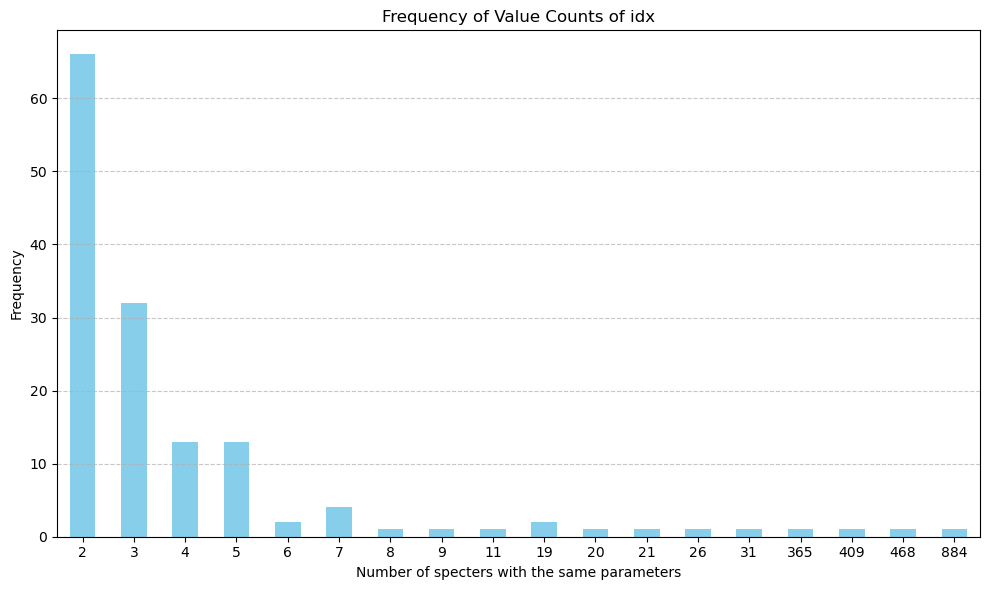

In [12]:
idx_counts = closest_times_stg3_no_change['idx'].value_counts()
count_frequencies = idx_counts.value_counts().sort_index()

plt.figure(figsize=(10, 6))
count_frequencies.plot(kind='bar', color='skyblue')
plt.title('Frequency of Value Counts of idx')
plt.xlabel('Number of specters with the same parameters')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Stage4

In [13]:
closest_times_stg4_no_change = get_non_unique_idx_rows(closest_times_stg4)
closest_times_stg4_no_change.head()

Time_spectrum  \
13  2024-06-17 08:59:14.669630527   
14  2024-06-17 08:59:15.522633553   
31  2024-06-17 08:59:33.183339119   
32  2024-06-17 08:59:34.237629414   
118 2024-06-17 09:01:04.464854240   

                                           Intensities  \
13   [2.04433, -6.42062, -9.35264, 8.78973, -0.9214...   
14   [0.04433, -4.42062, -5.35264, 8.78973, 1.07852...   
31   [-1.95567, -10.42062, -11.35264, 6.78973, -4.9...   
32   [2.04433, -6.42062, -9.35264, 12.78973, -2.921...   
118  [8.04433, -0.42062, -9.35264, 8.78973, 1.07852...   

                                           Wavelengths  \
13   [634.83514, 635.297, 635.75891, 636.22083, 636...   
14   [634.83514, 635.297, 635.75891, 636.22083, 636...   
31   [634.83514, 635.297, 635.75891, 636.22083, 636...   
32   [634.83514, 635.297, 635.75891, 636.22083, 636...   
118  [634.83514, 635.297, 635.75891, 636.22083, 636...   

                  Time_parameters  Stage3_OutputPower  Stage3_Piezo  \
13  2024-06-17 08:59:14.472586155            0.121451           0.0   
14  2024-06-17 08:59:14.472586155            0.121451           0.0   
31  2024-06-17 08:59:32.858325005            0.162824           0.0   
32  2024-06-17 08:59:32.858325005            0.162824           0.0   
118 2024-06-17 09:01:04.373449802            0.149876           0.0   

     Stage4_OutputPower  Stage4_Piezo  Stage3_Stepper  Stage4_Stepper  idx  
13             0.157127           0.0       -176387.0       -289957.0   88  
14             0.157127           0.0       -176387.0       -289957.0   88  
31             0.265351           0.0       -176387.0       -289957.0  143  
32             0.265351           0.0       -176387.0       -289957.0  143  
118            0.240917           0.0       -176387.0       -289957.0  516

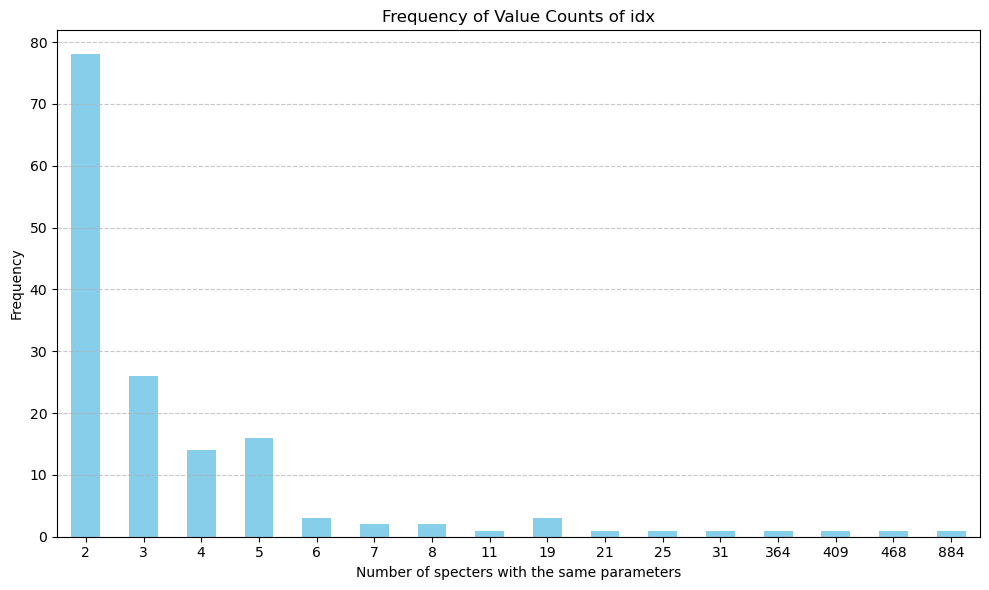

In [14]:
idx_counts = closest_times_stg4_no_change['idx'].value_counts()
count_frequencies = idx_counts.value_counts().sort_index()

plt.figure(figsize=(10, 6))
count_frequencies.plot(kind='bar', color='skyblue')
plt.title('Frequency of Value Counts of idx')
plt.xlabel('Number of specters with the same parameters')
plt.ylabel('Frequency')
plt.xticks(rotation=0) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Make spectograms

In [15]:
# Check if Wavelengths are the same for each row
print(closest_times_stg3_no_change['Wavelengths'].nunique())
print(closest_times_stg4_no_change['Wavelengths'].nunique())

1
1


In [16]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_spectrogram(df, specific_idx):
    """
    Creates a 3D spectrogram for a specific idx from the DataFrame.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing 'Time_spectrum', 'Intensities', 'Wavelengths', and 'idx' columns.
    - specific_idx (int): The specific idx to filter the DataFrame.
    
    Returns:
    - None: Displays the 3D spectrogram plot.
    """
    # Filter the DataFrame based on the specific idx
    filtered_df = df[df['idx'] == specific_idx]
        
    if filtered_df.empty:
        print(f"No data found for idx: {specific_idx}")
        return
    
    # Prepare data for plotting
    times = pd.to_datetime(filtered_df['Time_spectrum'])
    wavelengths = np.array(eval(filtered_df['Wavelengths'].iloc[0]))
    intensities = np.array([eval(intensity) for intensity in filtered_df['Intensities']])
    
    # Create meshgrid for the 3D plot
    T, W = np.meshgrid(times.astype(np.int64) / 1e9, wavelengths)
    
    # Plotting
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot surface
    surf = ax.plot_surface(T, W, intensities.T, cmap='viridis')

    # Set plot labels
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Wavelength (nm)")
    ax.set_zlabel("Intensity")
    ax.set_title(f"3D Spectrogram for idx: {specific_idx}, number of datapoints: {len(filtered_df)}")
    
    # Add color bar for intensity scale
    fig.colorbar(surf, ax=ax, label="Intensity")

    plt.show()


In [17]:
def plot_for_frequent_indices(df, threshold):
    # Get counts of each idx
    idx_counts = df['idx'].value_counts()
    
    # Filter to get idx values with count > threshold
    frequent_indices = idx_counts[idx_counts > threshold].index
    
    # Plot for each frequent idx
    for specific_idx in frequent_indices:
        plot_3d_spectrogram(df, specific_idx)

### Stage 3

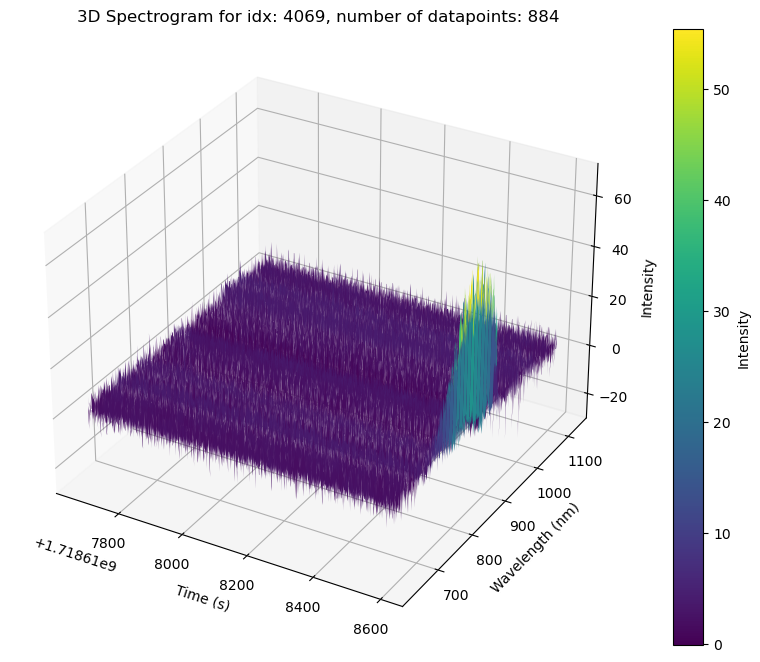

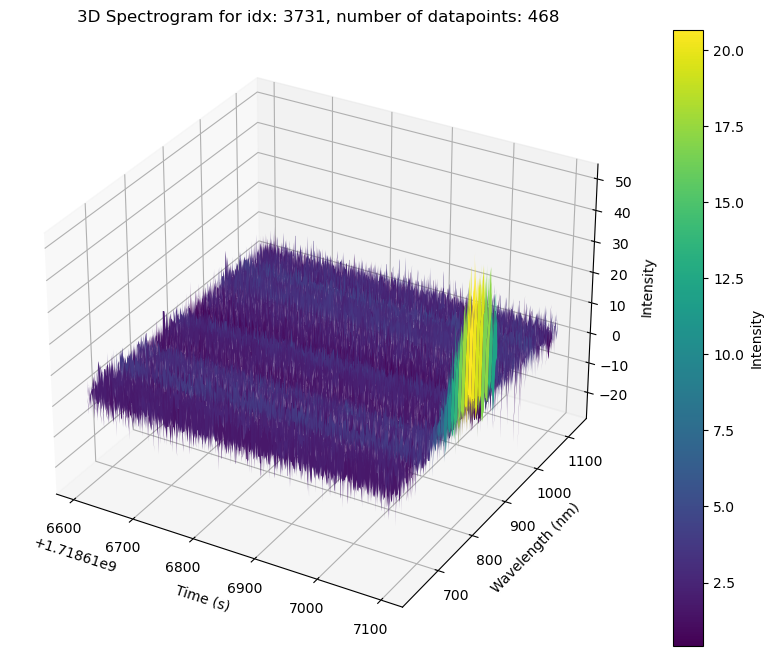

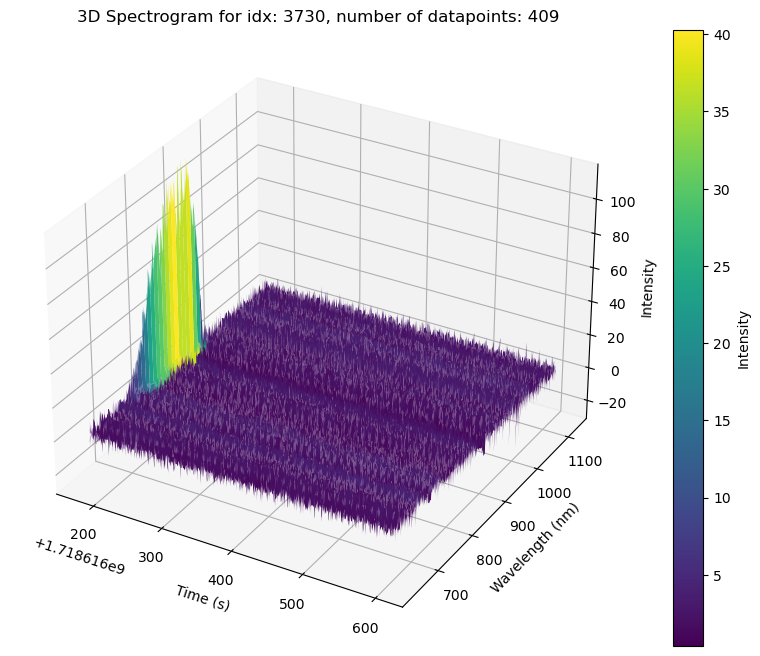

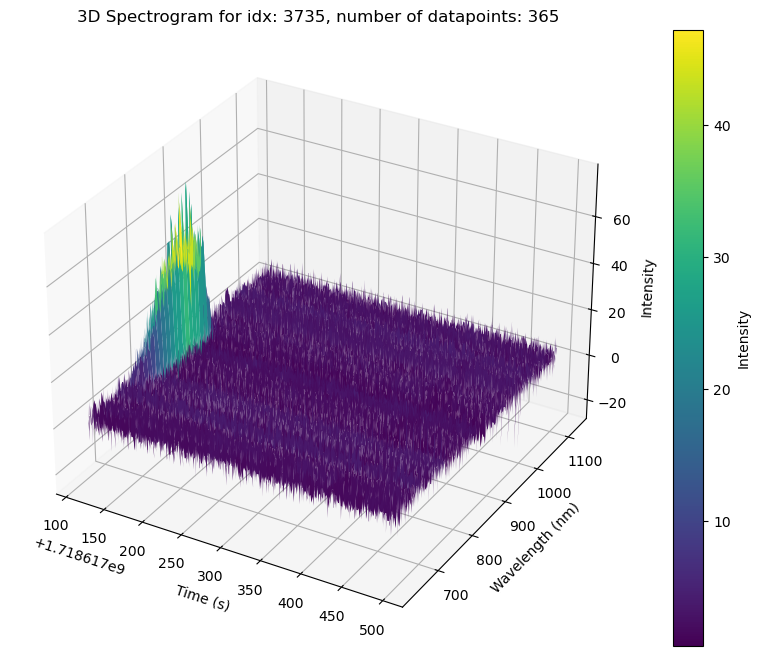

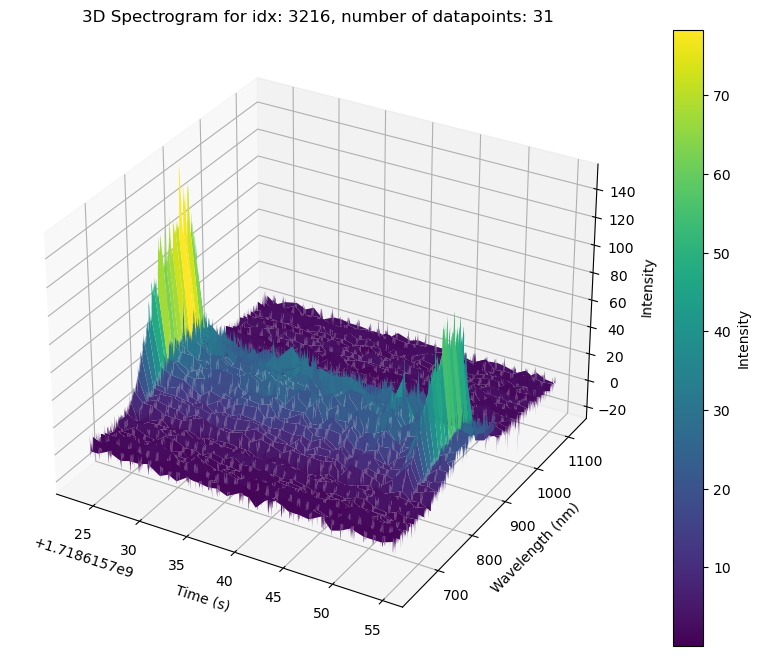

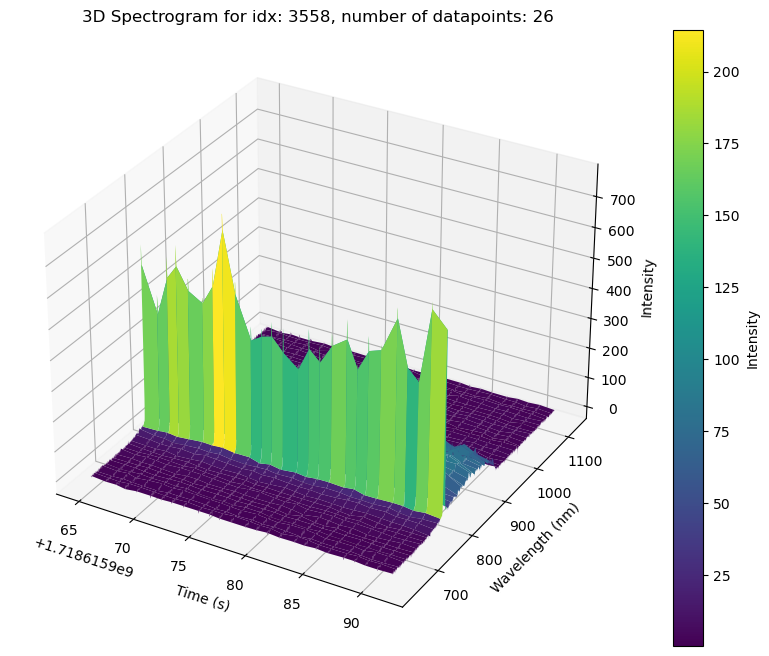

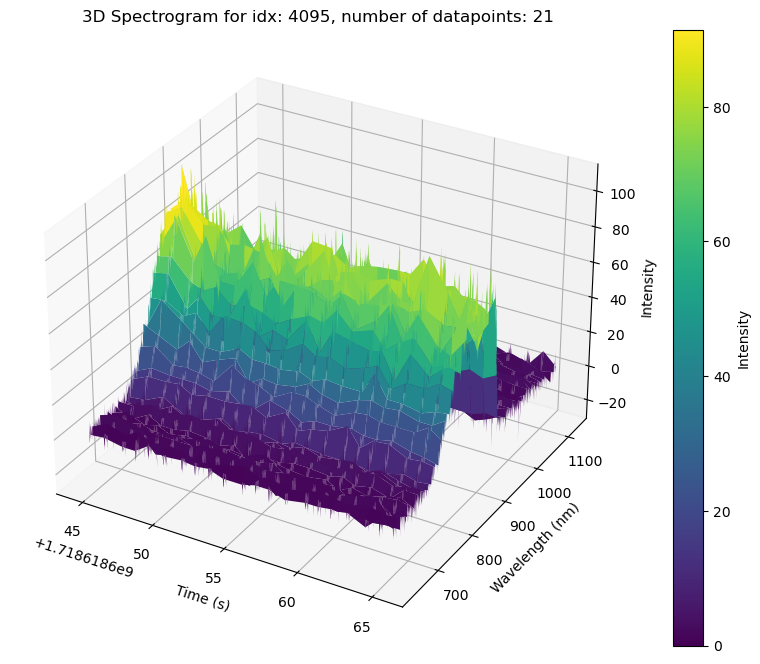

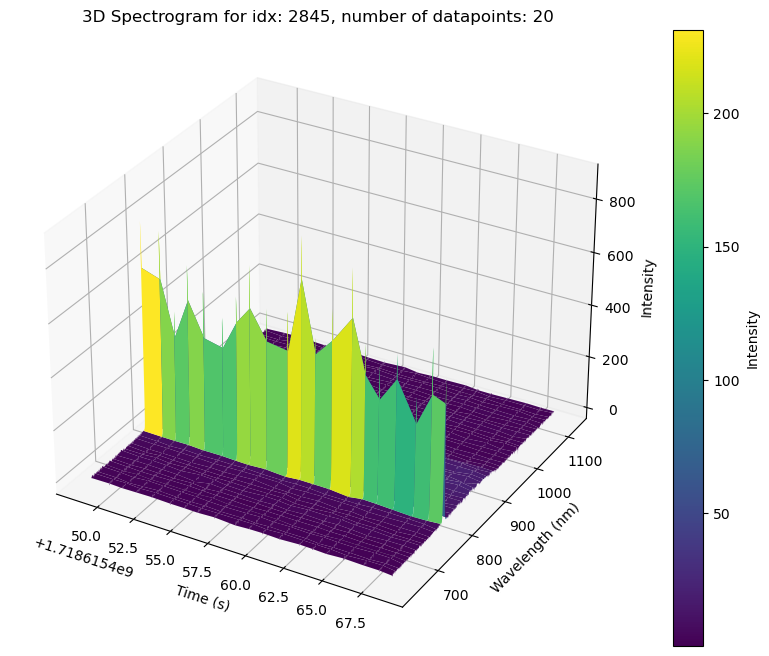

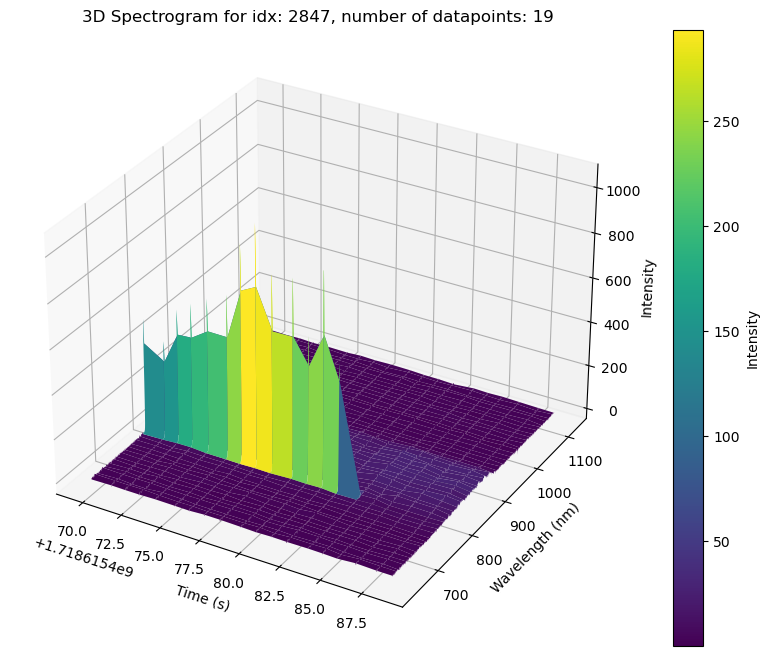

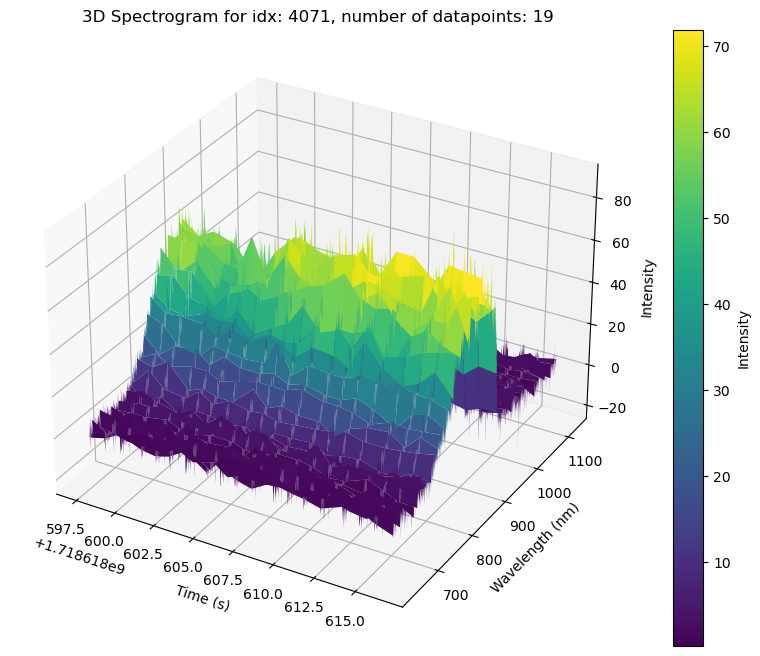

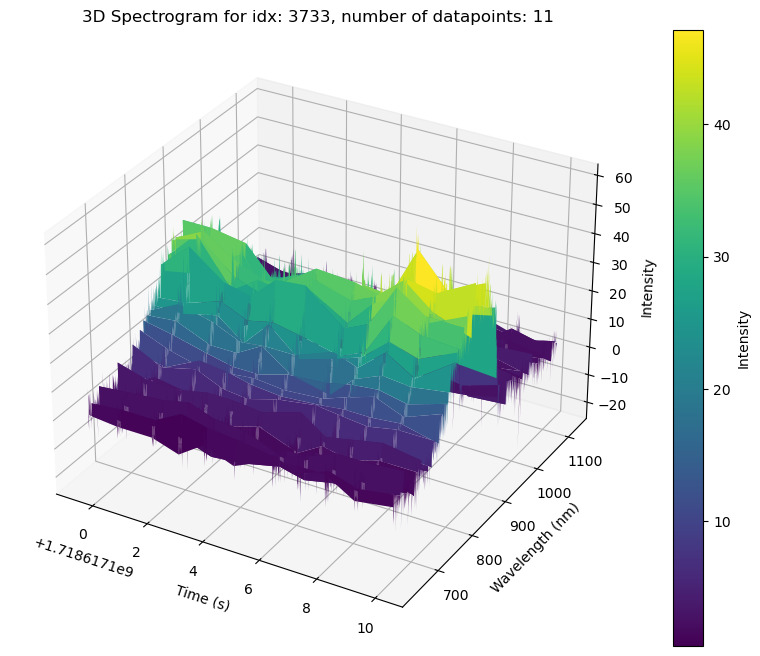

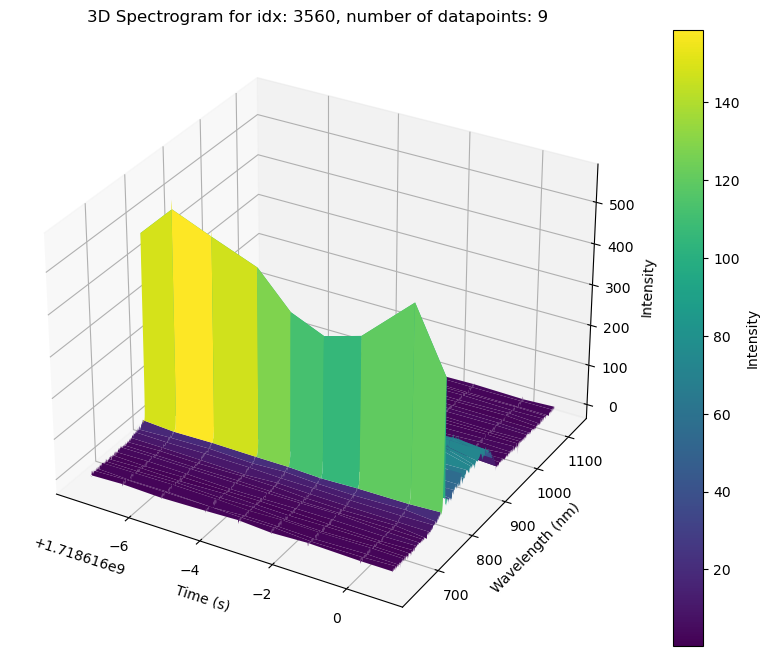

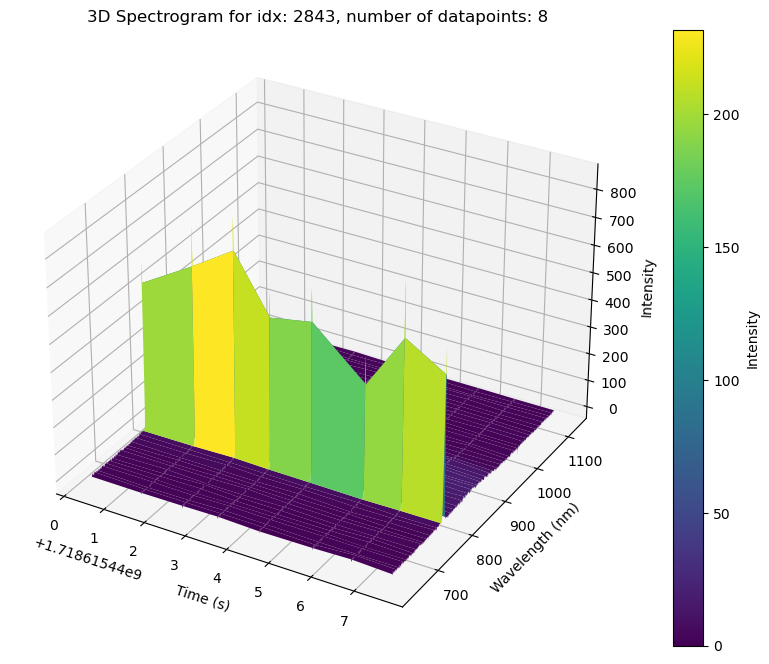

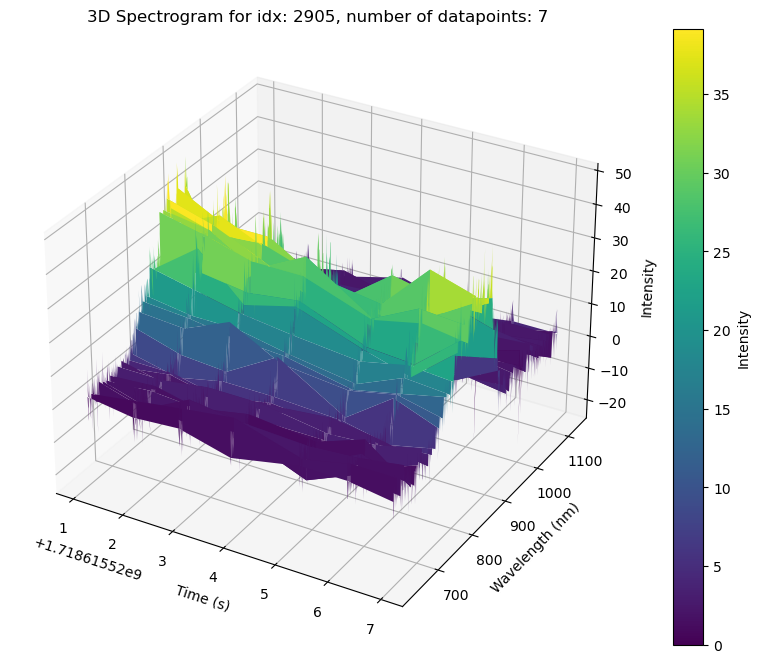

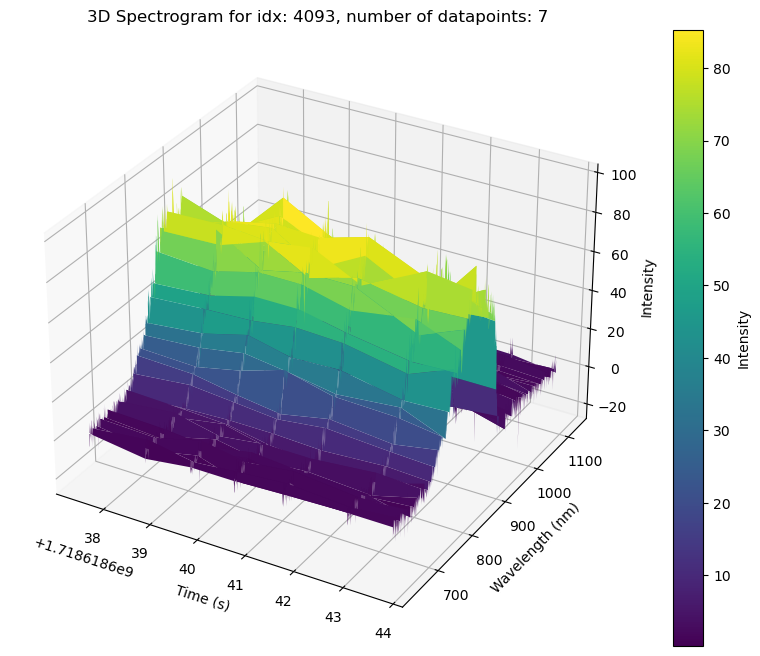

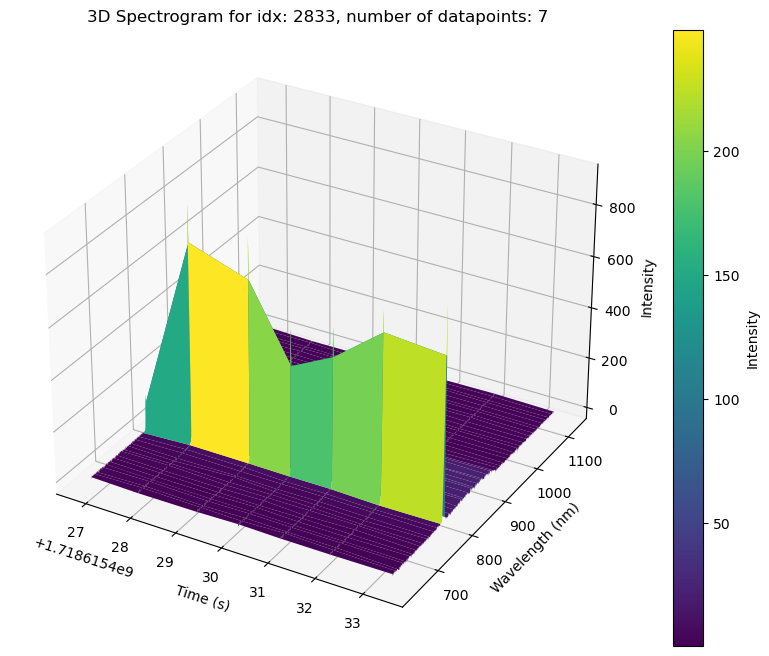

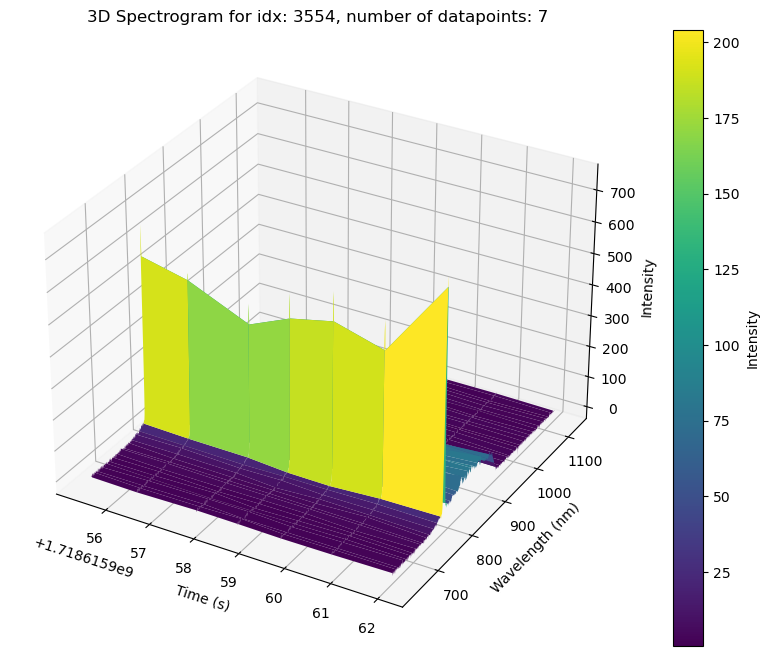

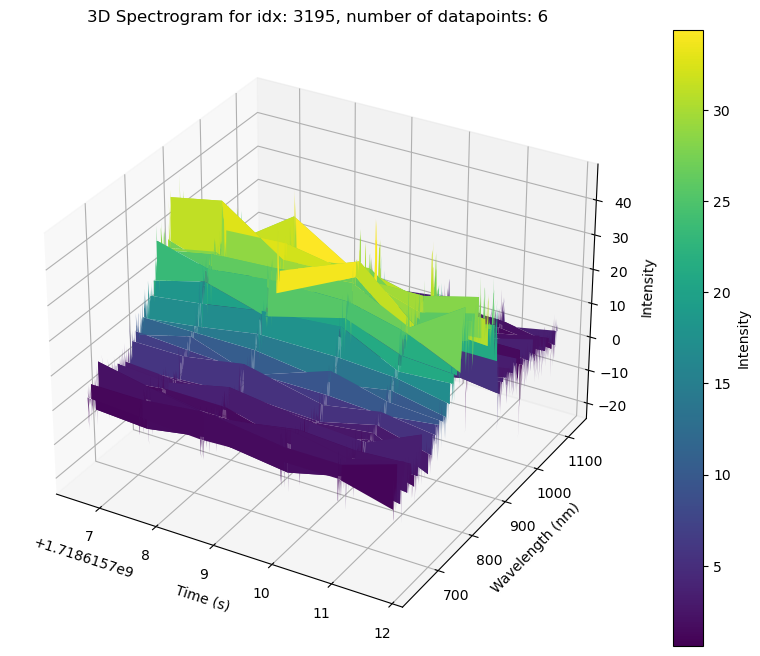

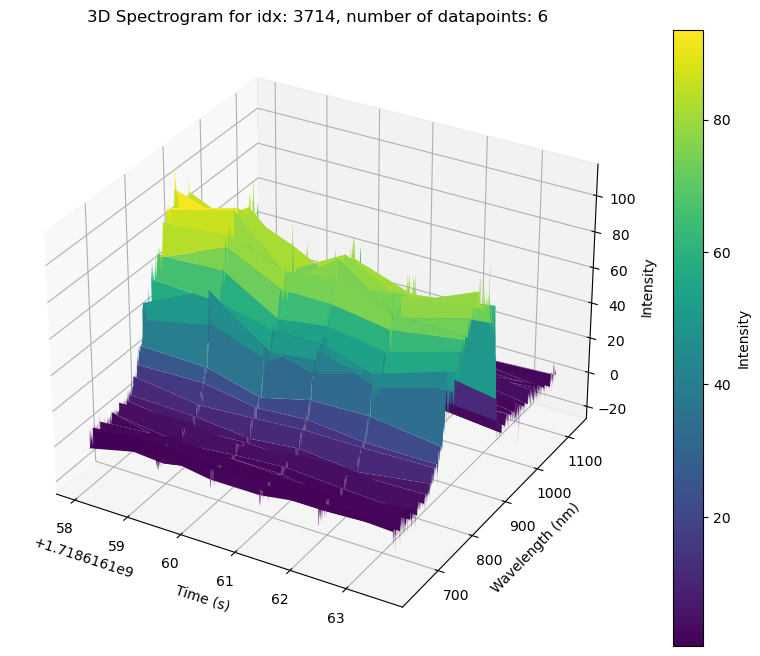

In [18]:
plot_for_frequent_indices(closest_times_stg3_no_change, 5)

### Stage 4

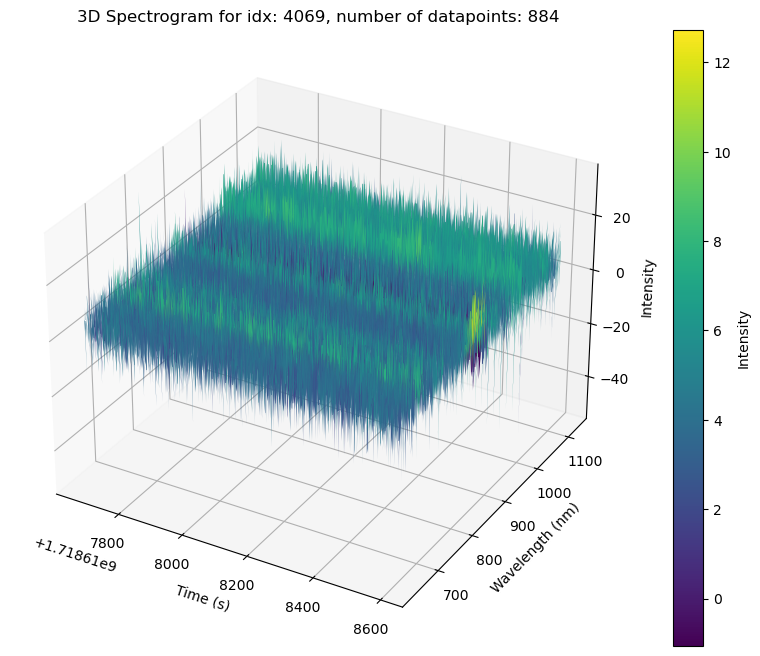

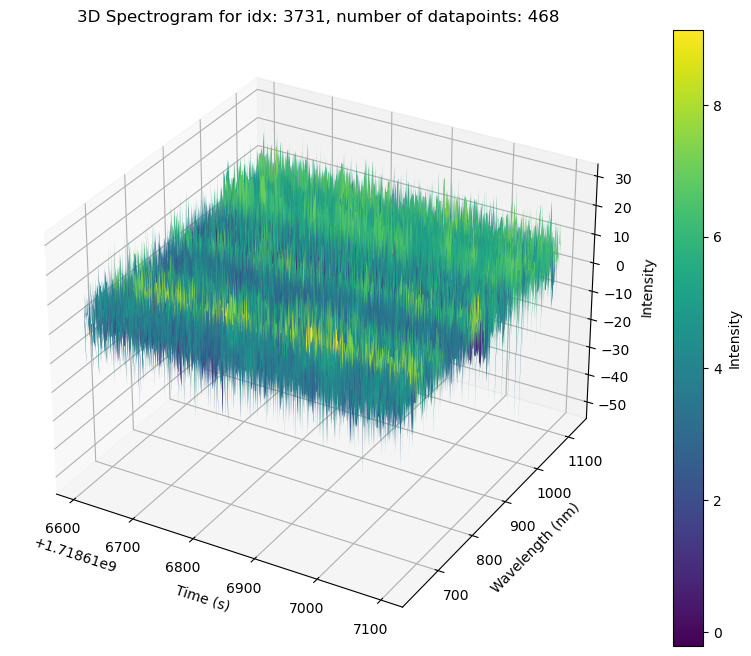

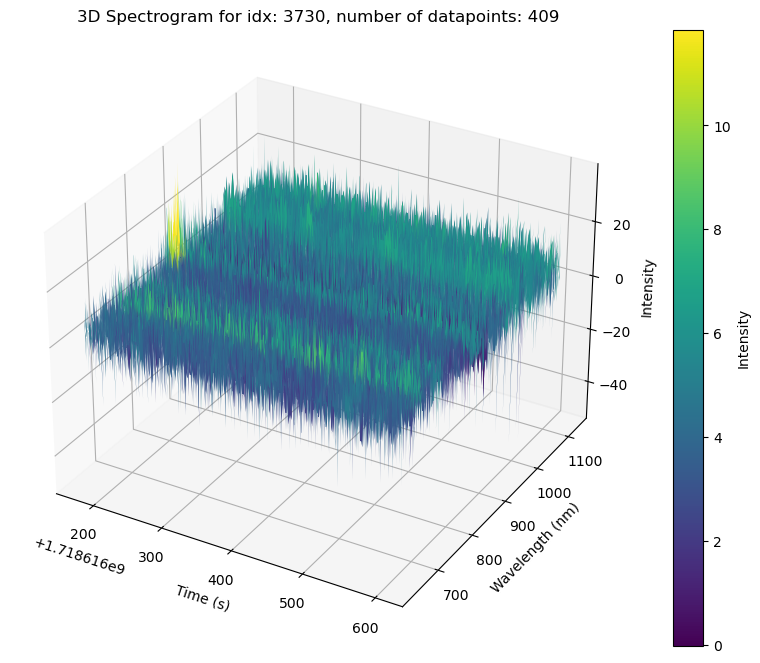

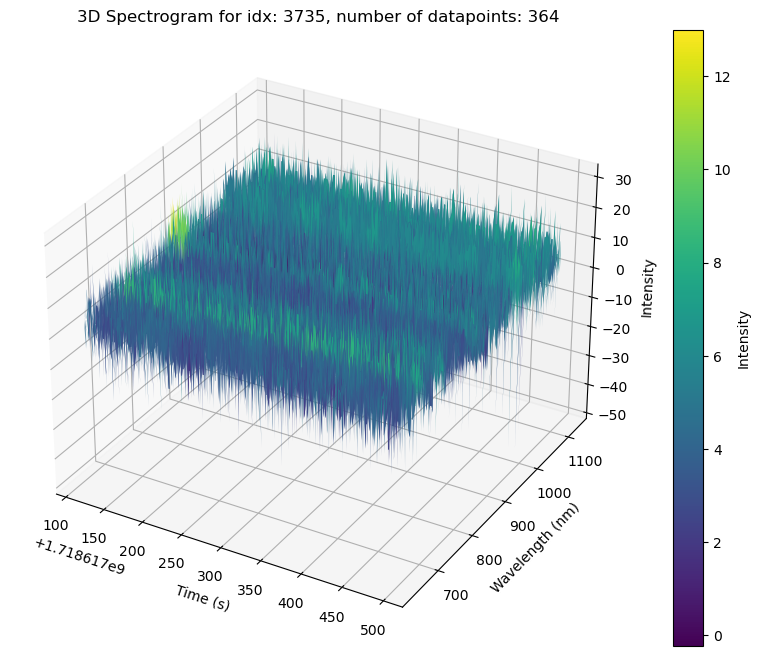

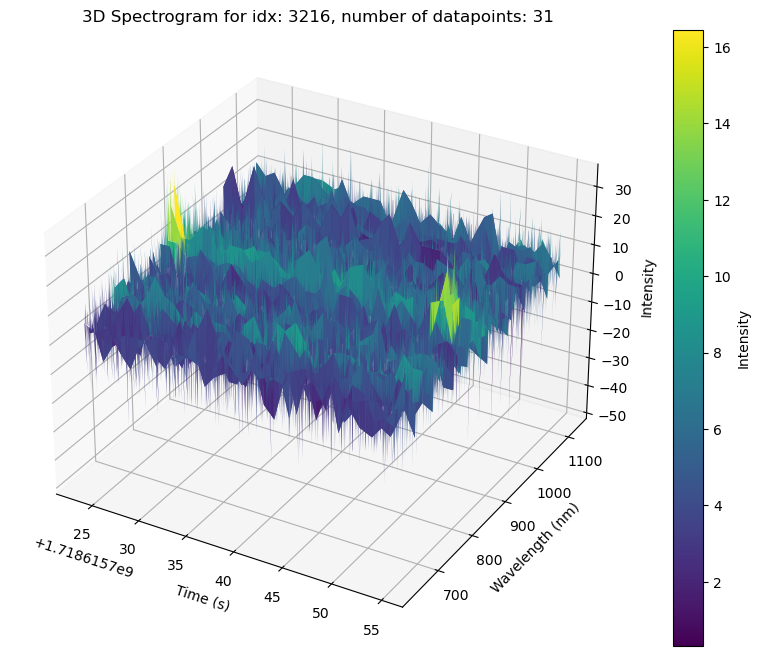

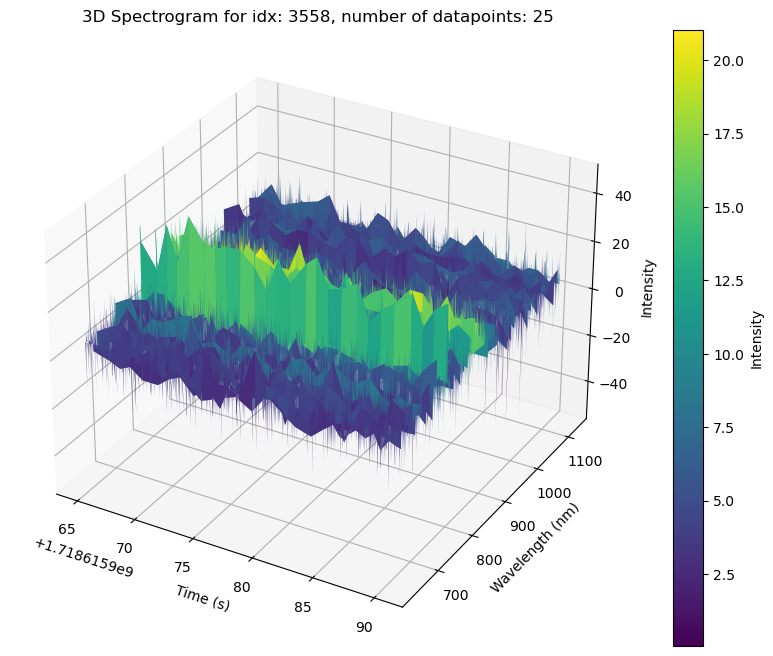

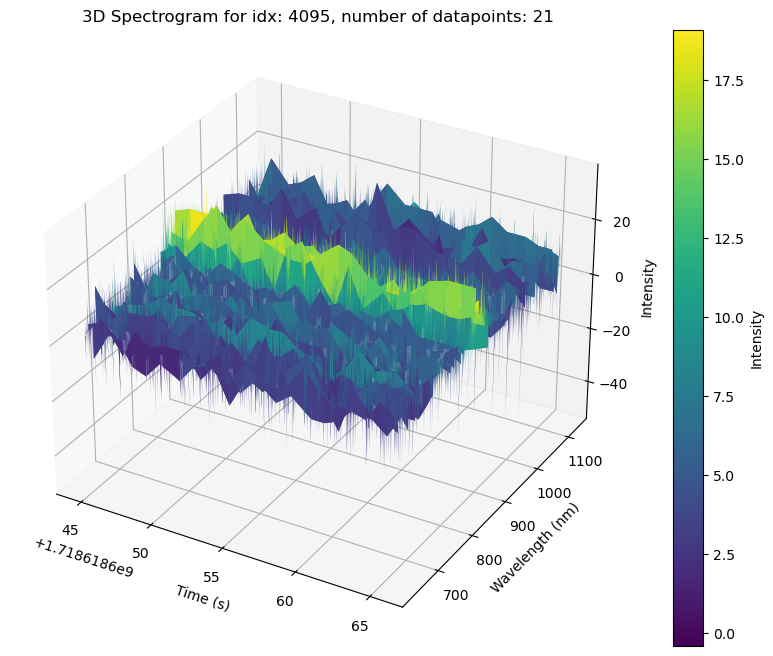

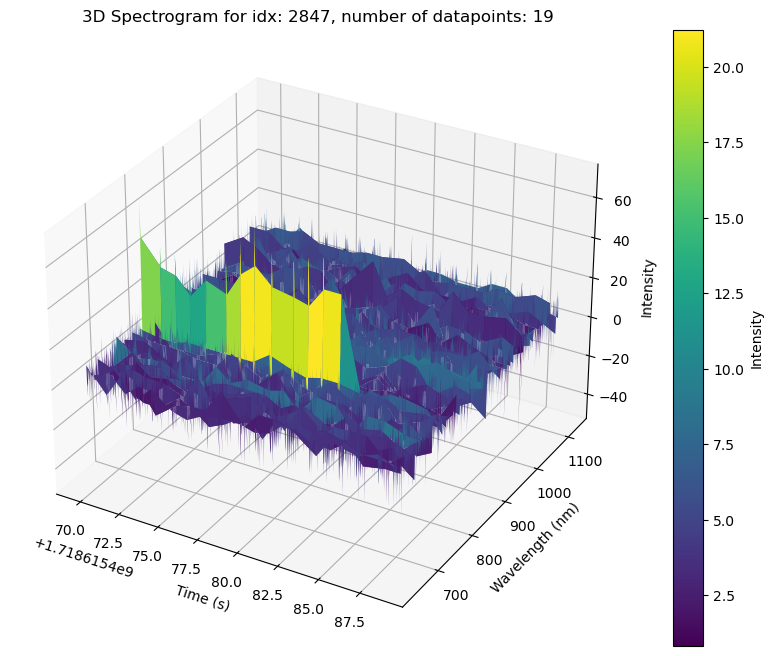

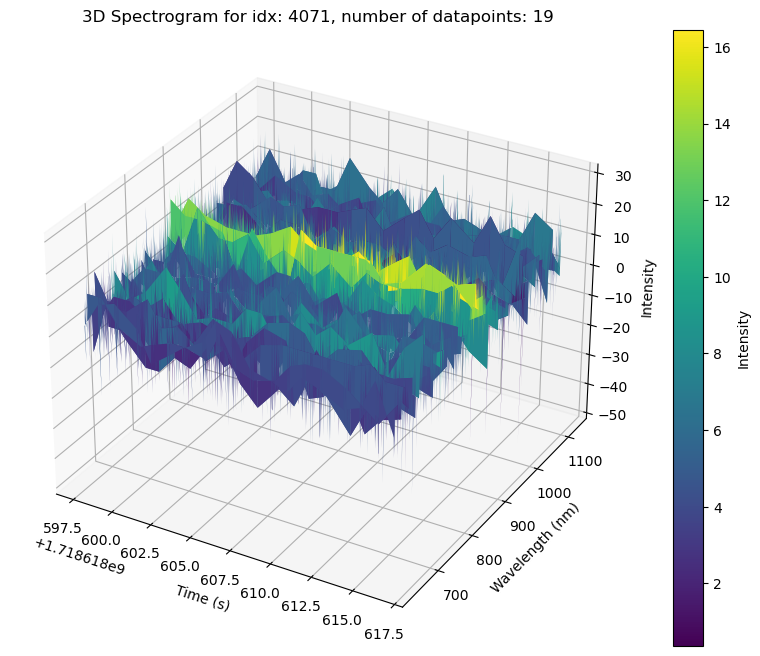

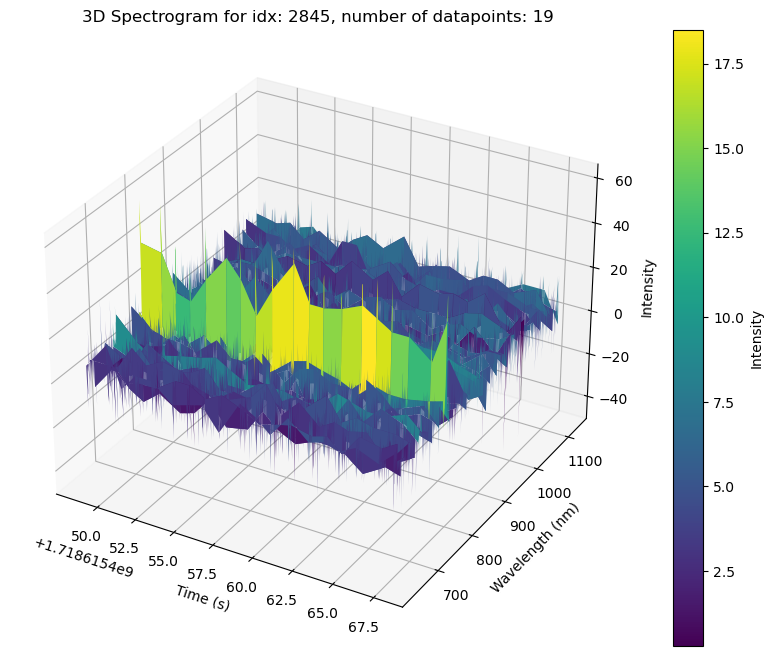

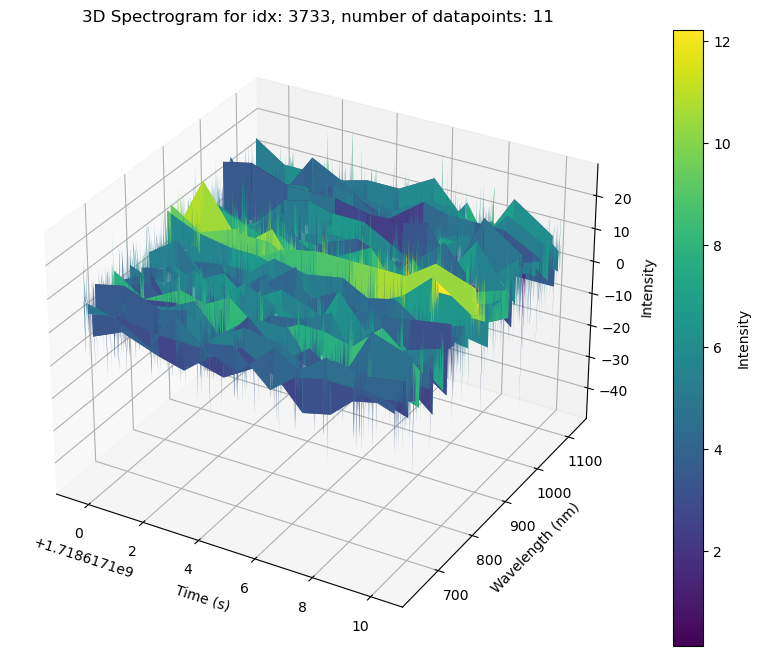

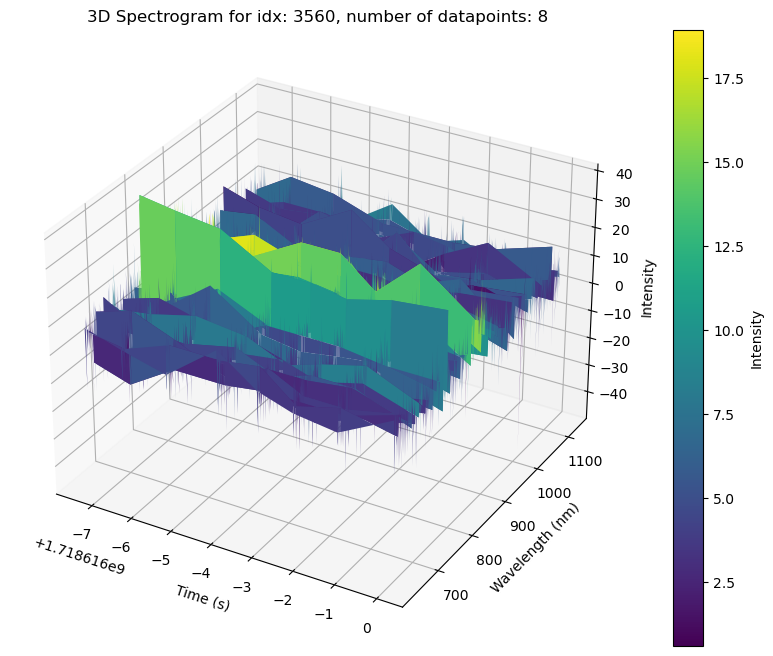

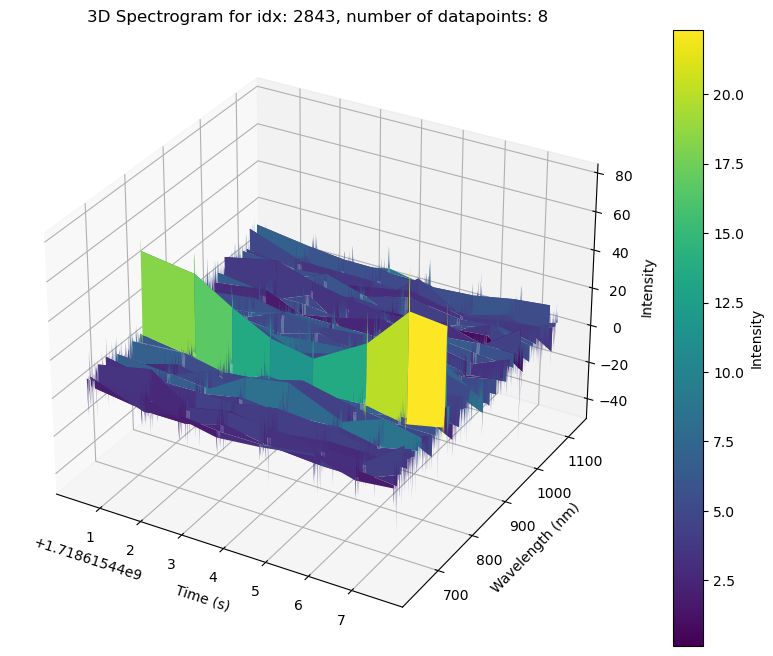

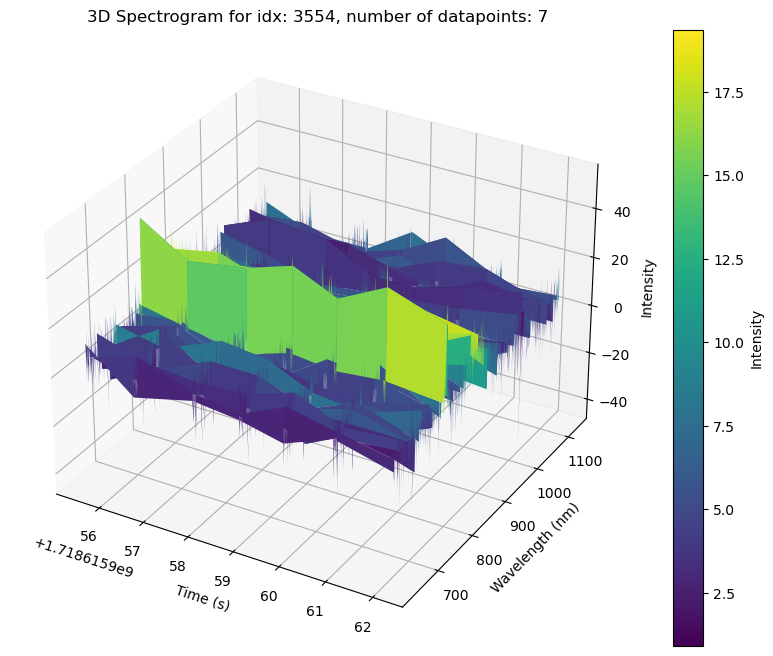

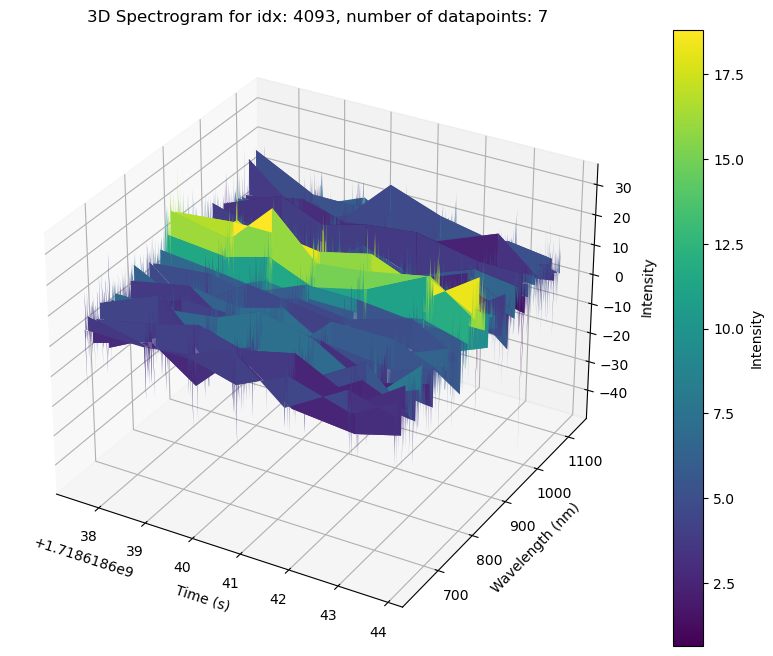

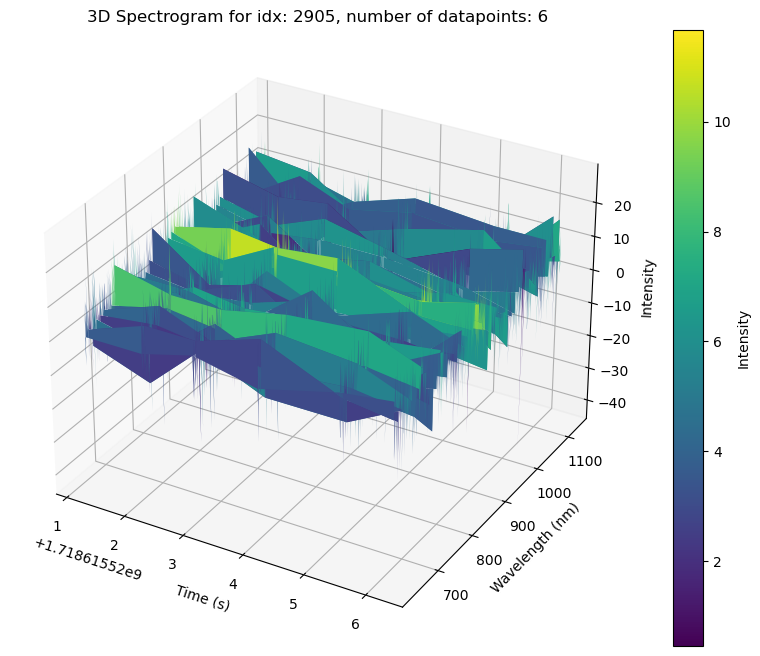

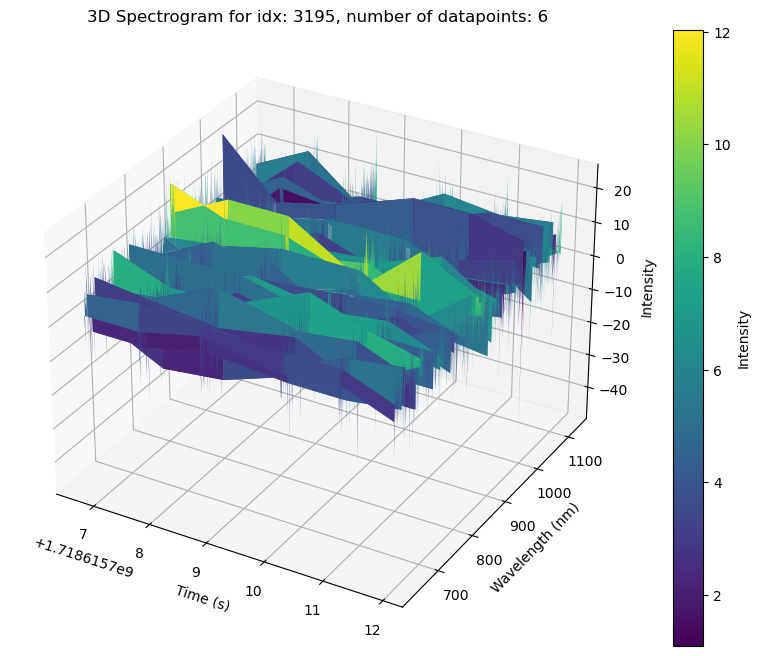

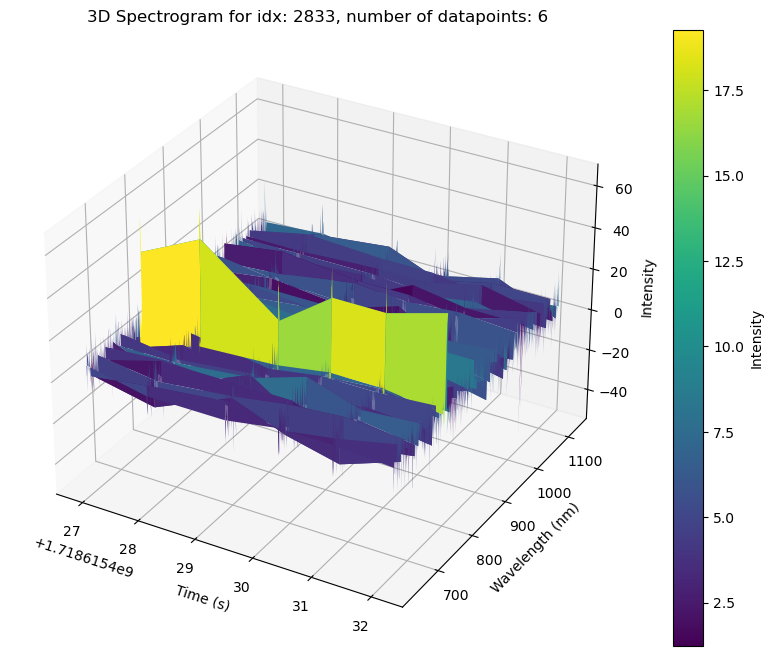

In [19]:
plot_for_frequent_indices(closest_times_stg4_no_change, 5)

# Save datasets

In [20]:
closest_times_stg4_no_change.to_csv('data/closest_times_stg4_no_change.csv', index=False)
closest_times_stg3_no_change.to_csv('data/closest_times_stg3_no_change.csv', index=False)